# Improved LSTM baseline

[Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

In [3]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


Link to download the the [GloVe word vectors](https://www.kaggle.com/yliu9999/glove6b50d/downloads/glove.6B.50d.txt).

In [4]:
path = './data/'
EMBEDDING_FILE=f'{path}glove.6B.50d.txt'
TRAIN_DATA_FILE=f'{path}train.csv'
TEST_DATA_FILE=f'{path}test.csv'

Set some basic config parameters:

In [5]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

Read in our data and replace missing values:

In [6]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(list_sentences_train, y, test_size=0.2, random_state=42)

Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [8]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
# list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
# list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

In [9]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [10]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.020940498, 0.6441043)

In [11]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

In [12]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now we're ready to fit out model! Use `validation_split` when not submitting.

In [13]:
model.fit(X_t, y_train, batch_size=32, epochs=2) # validation_split=0.1);

Epoch 1/2
127656/127656 [==============================] - 1406s - loss: 0.0681 - acc: 0.9770  
Epoch 2/2
127656/127656 [==============================] - 1187s - loss: 0.0495 - acc: 0.9817  


In [14]:
y_pred = model.predict([X_te], batch_size=1024, verbose=1)
# sample_submission = pd.read_csv(f'{path}sample_submission.csv')
# sample_submission[list_classes] = y_test
# sample_submission.to_csv('submission.csv', index=False)

31915/31915 [==============================] - 47s    


In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

print(f'y_test shape: {y_test[:,0].shape}')
print(f'y_pred shape: {y_pred[:,0].shape}')

tox_fpr, tox_tpr, thresholds = roc_curve(y_test[:,0], y_pred[:,0])
stox_fpr, stox_tpr, thresholds = roc_curve(y_test[:,1], y_pred[:,1])
obs_fpr, obs_tpr, thresholds = roc_curve(y_test[:,2], y_pred[:,2])
thr_fpr, thr_tpr, thresholds = roc_curve(y_test[:,3], y_pred[:,3])
ins_fpr, ins_tpr, thresholds = roc_curve(y_test[:,4], y_pred[:,4])
idh_fpr, idh_tpr, thresholds = roc_curve(y_test[:,5], y_pred[:,5])

y_test shape: (31915,)
y_pred shape: (31915,)


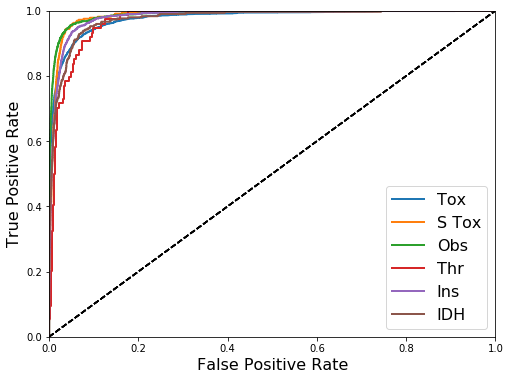

In [46]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(tox_fpr, tox_tpr, "Tox")
plot_roc_curve(stox_fpr, stox_tpr, "S Tox")
plot_roc_curve(obs_fpr, obs_tpr, "Obs")
plot_roc_curve(thr_fpr, thr_tpr, "Thr")
plot_roc_curve(ins_fpr, ins_tpr, "Ins")
plot_roc_curve(idh_fpr, idh_tpr, "IDH")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [48]:
tox_rocauc = roc_auc_score(y_test[:,0], y_pred[:,0])
stox_rocauc = roc_auc_score(y_test[:,1], y_pred[:,1])
obs_rocauc = roc_auc_score(y_test[:,2], y_pred[:,2])
thr_rocauc = roc_auc_score(y_test[:,3], y_pred[:,3])
ins_rocauc = roc_auc_score(y_test[:,4], y_pred[:,4])
idh_rocauc = roc_auc_score(y_test[:,5], y_pred[:,5])

print(f'Toxic: {tox_rocauc}')
print(f'S Tox: {stox_rocauc}')
print(f'Obs:   {obs_rocauc}')
print(f'Thr:   {thr_rocauc}')
print(f'Ins:   {ins_rocauc}')
print(f'IDH:   {idh_rocauc}')

Toxic: 0.9773197743442615
S Tox: 0.9861784652119562
Obs:   0.988624495588207
Thr:   0.9724186986521712
Ins:   0.9818022556581923
IDH:   0.9762195729308453


In [49]:
avg_rocauc = (tox_rocauc+stox_rocauc+obs_rocauc+thr_rocauc+ins_rocauc+idh_rocauc)/6

print(f'Average ROC AUC: {avg_rocauc}')

Average ROC AUC: 0.9804272103976056


Create a classifier for just Thr 

In [50]:
thr_inp = Input(shape=(maxlen,))
thr_x = Embedding(max_features, embed_size, weights=[embedding_matrix])(thr_inp)
thr_x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(thr_x)
thr_x = GlobalMaxPool1D()(thr_x)
thr_x = Dense(50, activation="relu")(thr_x)
thr_x = Dropout(0.1)(thr_x)
thr_x = Dense(1, activation="sigmoid")(thr_x)
thr_model = Model(inputs=thr_inp, outputs=thr_x)
thr_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
thr_model.fit(X_t, y_train[:,3], batch_size=32, epochs=2, validation_split=0.1)

Train on 114890 samples, validate on 12766 samples
Epoch 1/2
114890/114890 [==============================] - 1171s - loss: 0.0155 - acc: 0.9963 - val_loss: 0.0104 - val_acc: 0.9966
Epoch 2/2
114890/114890 [==============================] - 1183s - loss: 0.0073 - acc: 0.9975 - val_loss: 0.0122 - val_acc: 0.9965


In [ ]:
thr_pred = thr_model.predict([X_te], batch_size=1024, verbose=1)

In [ ]:
thr_rocauc = roc_auc_score(y_test[:,3], thr_pred)
print(f'Thr:   {thr_rocauc}')

In [ ]:
avg_rocauc = (tox_rocauc+stox_rocauc+obs_rocauc+thr_rocauc+ins_rocauc+idh_rocauc)/6

print(f'Average ROC AUC: {avg_rocauc}')